<a href="https://colab.research.google.com/github/AbdelrahmanSalem9/MNIST-Dataset-Pytorch/blob/main/MNIST_Dataset_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Imports**

In [1]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

## **Download and Uploader MNIST Dataset**

In [2]:
(train_features, train_labels), (test_features, test_labels) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


## **Split the dataset from 60000 train | 10000 test into:**
1.   57000 train
2.   3000 validation
3.   10000 test



In [3]:
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size=0.05, random_state=42,stratify=train_labels)

## **Important Note**
we need to convert the dimension for each sample from (28,28) -> (1,28,28)
to fit to the CNN model as 1 is the number of in channels

In [4]:
train_features= train_features.reshape((train_features.shape[0], 1 ,28, 28))
test_features= test_features.reshape((test_features.shape[0], 1 ,28, 28))
val_features= val_features.reshape((val_features.shape[0], 1 ,28, 28))

## **Dataset Classes Distribution**

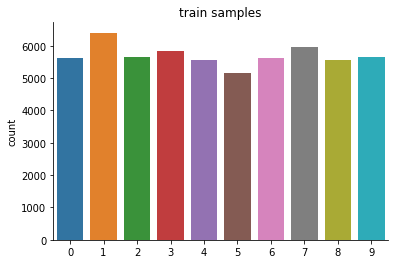

In [5]:
plt.title("train samples")
sns.countplot(x = train_labels)
sns.despine(top = True, right = True, left = False, bottom = False)

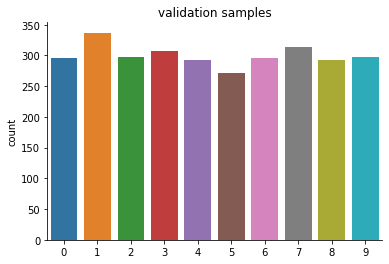

In [6]:
plt.title("validation samples")
sns.countplot(x = val_labels)
sns.despine(top = True, right = True, left = False, bottom = False)

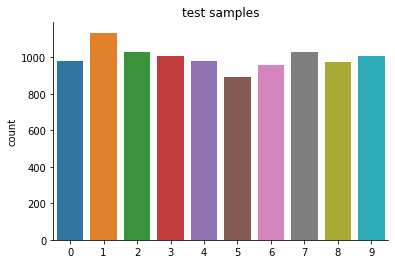

In [7]:
plt.title("test samples")
sns.countplot(x = test_labels)
sns.despine(top = True, right = True, left = False, bottom = False)

## **Construct the Dataloader class for the dataset --> need to implemet the custom class that inherits the torch dataset class or use the pre-defined one**

In [8]:
class dataset(Dataset):
  def __init__(self, feat_arr, label):
    self.feat_arr = feat_arr
    self.label = label
  def __getitem__(self, index):
    return torch.tensor(self.feat_arr[index]).float(),torch.tensor((self.label[index]))
  def __len__(self):
    return len(self.feat_arr)

In [9]:
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset(train_features,train_labels),batch_size = BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset(val_features,val_labels),batch_size = BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset(test_features,test_labels),batch_size = BATCH_SIZE, shuffle=True)

## **Make Sure the The GPU is On**

In [10]:
cuda = torch.cuda.is_available()
print("GPU:", cuda)

GPU: True


## **Your CNN model with your pre-defined architecture**

In [11]:
class Cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5,5),stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(5,5),stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=1)
        

        self.fc1 = nn.Linear(in_features = 7*7*24,out_features = 100)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=100,out_features=10)
  
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.log_softmax(self.fc2(x),dim=0)
        return x

model = Cnn()
if cuda: 
  model.cuda()

## **Define you own loss function and the optimizer and I am really recommend to follow such a table depending on your problem**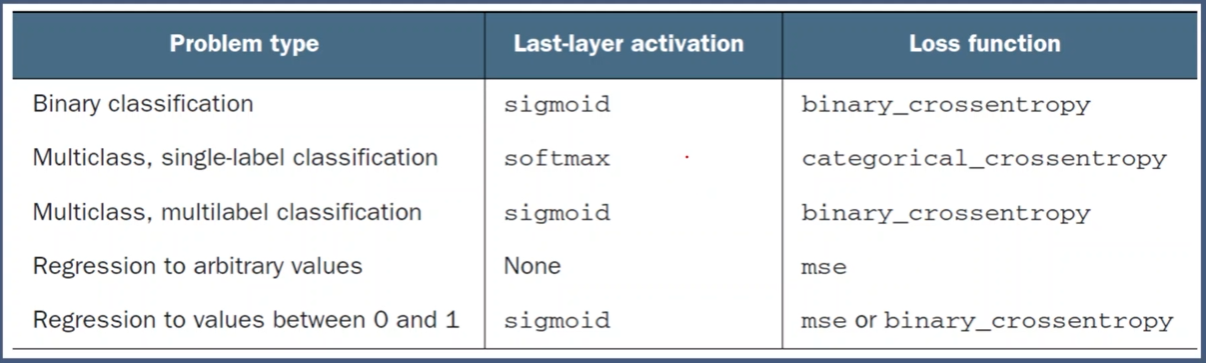

In [12]:
LEARNING_RATE = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)

## **Training Loop**

In [13]:
train_accu = []
train_losses = []
eval_losses=[]
eval_accu=[]

def train_model(model,epoch,train_dataloader,val_dataloader):
  print('\nEpoch : %d'%epoch)
   
  model.train()
 
  running_loss=0
  correct=0
  total=0
 
  for inputs,labels in tqdm(train_dataloader):
    if cuda:
      inputs,labels=inputs.cuda(),labels.cuda()
     
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
 
    running_loss += loss.item()
     
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
       
  train_loss=running_loss/len(train_dataloader)
  accu=correct/total
   
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Train Accuracy: %.3f'%(train_loss,accu),end=" | ")


  model.eval()
  running_loss=0
  correct=0
  total=0
 
  with torch.no_grad():
    for val_inputs,val_labels in val_dataloader:

      if cuda:
        val_inputs,val_labels = val_inputs.cuda(),val_labels.cuda()
       
      outputs=model(val_inputs)
 
      loss= loss_fn(outputs,val_labels)
      running_loss+=loss.item()
       
      _, predicted = outputs.max(1)
      total += val_labels.size(0)
      correct += predicted.eq(val_labels).sum().item()
   
  val_loss=running_loss/len(val_dataloader)
  accu=correct/total
 
  eval_losses.append(val_loss)
  eval_accu.append(accu)
 
  print('Val Loss: %.3f | Validation Accuracy: %.3f'%(val_loss,accu))


## **Testing Your Model**

In [14]:
y_pred=[]
y_true=[]
def test_model(model,test_dataloader):
  model.eval()
  running_loss=0
  correct=0
  total=0
 
  with torch.no_grad():
    for test_inputs,test_labels in test_dataloader:

      if cuda:
        test_inputs,test_labels = test_inputs.cuda(),test_labels.cuda()
       
      outputs=model(test_inputs)
 
      loss= loss_fn(outputs,test_labels)
      running_loss+=loss.item()
       
      _, predicted = outputs.max(1)
      total += test_labels.size(0)
      correct += predicted.eq(test_labels).sum().item()
   
      test_loss=running_loss/len(test_dataloader)
      accu=correct/total
 
      y_pred.extend((torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()) # Save Prediction
      test_labels = test_labels.data.cpu().numpy()
      y_true.extend(test_labels) # Save Truth
 
  print('test Accuracy: %.3f'%(accu))

In [15]:
EPOCHS=20
for epoch in range(1,EPOCHS+1): 
  train_model(model,epoch,train_dataloader,val_dataloader)


Epoch : 1


100%|██████████| 1782/1782 [00:06<00:00, 263.47it/s]


Train Loss: 0.418 | Train Accuracy: 0.871 | Val Loss: 0.118 | Validation Accuracy: 0.965

Epoch : 2


100%|██████████| 1782/1782 [00:06<00:00, 277.43it/s]


Train Loss: 0.173 | Train Accuracy: 0.944 | Val Loss: 0.142 | Validation Accuracy: 0.953

Epoch : 3


100%|██████████| 1782/1782 [00:06<00:00, 289.53it/s]


Train Loss: 0.154 | Train Accuracy: 0.950 | Val Loss: 0.120 | Validation Accuracy: 0.965

Epoch : 4


100%|██████████| 1782/1782 [00:06<00:00, 294.16it/s]


Train Loss: 0.141 | Train Accuracy: 0.953 | Val Loss: 0.098 | Validation Accuracy: 0.970

Epoch : 5


100%|██████████| 1782/1782 [00:06<00:00, 295.24it/s]


Train Loss: 0.137 | Train Accuracy: 0.955 | Val Loss: 0.120 | Validation Accuracy: 0.966

Epoch : 6


100%|██████████| 1782/1782 [00:06<00:00, 295.16it/s]


Train Loss: 0.126 | Train Accuracy: 0.959 | Val Loss: 0.097 | Validation Accuracy: 0.970

Epoch : 7


100%|██████████| 1782/1782 [00:06<00:00, 296.71it/s]


Train Loss: 0.126 | Train Accuracy: 0.959 | Val Loss: 0.106 | Validation Accuracy: 0.968

Epoch : 8


100%|██████████| 1782/1782 [00:06<00:00, 293.94it/s]


Train Loss: 0.122 | Train Accuracy: 0.959 | Val Loss: 0.109 | Validation Accuracy: 0.968

Epoch : 9


100%|██████████| 1782/1782 [00:06<00:00, 295.99it/s]


Train Loss: 0.121 | Train Accuracy: 0.960 | Val Loss: 0.119 | Validation Accuracy: 0.971

Epoch : 10


100%|██████████| 1782/1782 [00:07<00:00, 252.32it/s]


Train Loss: 0.114 | Train Accuracy: 0.962 | Val Loss: 0.168 | Validation Accuracy: 0.956

Epoch : 11


100%|██████████| 1782/1782 [00:06<00:00, 296.80it/s]


Train Loss: 0.112 | Train Accuracy: 0.963 | Val Loss: 0.135 | Validation Accuracy: 0.963

Epoch : 12


100%|██████████| 1782/1782 [00:06<00:00, 293.25it/s]


Train Loss: 0.114 | Train Accuracy: 0.962 | Val Loss: 0.121 | Validation Accuracy: 0.973

Epoch : 15


100%|██████████| 1782/1782 [00:06<00:00, 293.09it/s]


Train Loss: 0.112 | Train Accuracy: 0.963 | Val Loss: 0.142 | Validation Accuracy: 0.971

Epoch : 16


100%|██████████| 1782/1782 [00:06<00:00, 292.61it/s]


Train Loss: 0.120 | Train Accuracy: 0.962 | Val Loss: 0.140 | Validation Accuracy: 0.965

Epoch : 17


100%|██████████| 1782/1782 [00:05<00:00, 297.35it/s]


Train Loss: 0.113 | Train Accuracy: 0.963 | Val Loss: 0.136 | Validation Accuracy: 0.971

Epoch : 18


100%|██████████| 1782/1782 [00:06<00:00, 295.49it/s]


Train Loss: 0.112 | Train Accuracy: 0.963 | Val Loss: 0.159 | Validation Accuracy: 0.971

Epoch : 19


100%|██████████| 1782/1782 [00:05<00:00, 297.08it/s]


Train Loss: 0.119 | Train Accuracy: 0.963 | Val Loss: 0.114 | Validation Accuracy: 0.975

Epoch : 20


100%|██████████| 1782/1782 [00:06<00:00, 296.42it/s]


Train Loss: 0.111 | Train Accuracy: 0.964 | Val Loss: 0.131 | Validation Accuracy: 0.968


## **Results**

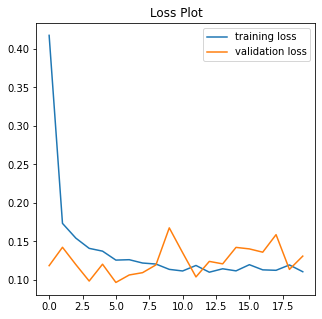

In [16]:
plt.figure(figsize=(5,5))
plt.title("Loss Plot")
plt.plot(train_losses,label='training loss')
plt.plot(eval_losses,label='validation loss')
plt.legend(loc='upper right')

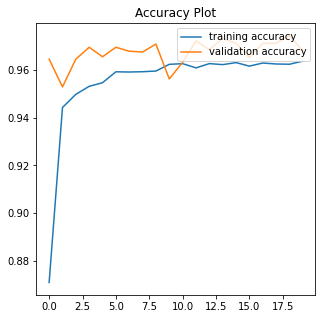

In [17]:
plt.figure(figsize=(5,5))
plt.title("Accuracy Plot")
plt.plot(train_accu,label='training accuracy')
plt.plot(eval_accu,label='validation accuracy')
plt.legend(loc='upper right')

In [18]:
test_model(model,test_dataloader)

test Accuracy: 0.974


Text(0.5, 1.0, 'Confusion Matrix for MNIST Dataset Classification')

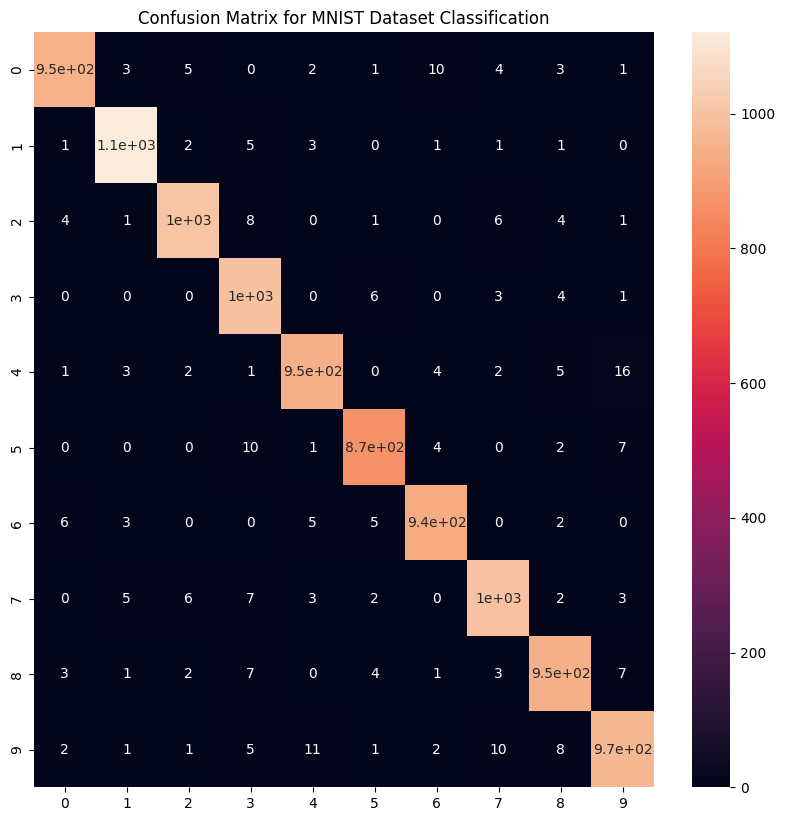

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true,y_pred)
plt.figure(figsize = (10,10),dpi=100)
sns.heatmap(cm,annot=True)
plt.title("Confusion Matrix for MNIST Dataset Classification")

## **Visualize the Feature maps and kernels**

In [82]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# for each layer we need to call it and store the weight values in activation map
model.conv1.register_forward_hook(get_activation('conv1'))
model.pool1.register_forward_hook(get_activation('pool1'))
model.conv2.register_forward_hook(get_activation('conv2'))
model.pool2.register_forward_hook(get_activation('pool2'))

In [99]:
def visualize_feature_maps(model,sample,layer,number_of_maps):
  model = model.cpu()
  output = model(sample)

  act = activation[layer].squeeze()
  fig, axarr = plt.subplots(min(act.size(0), number_of_maps),figsize=(8, 5))
  for idx in range(min(act.size(0), number_of_maps)):
      axarr[idx].imshow(act[idx])

torch.Size([1, 1, 28, 28])


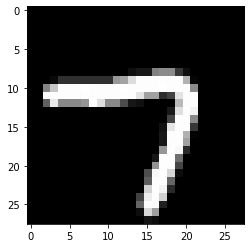

In [84]:
sample, _ = next(iter(test_dataloader))
sample = sample[0]
sample = sample.unsqueeze_(0)
print(sample.shape)
plt.title("Original Image in Gray")
plt.imshow(sample.squeeze(),cmap=plt.get_cmap('gray'))

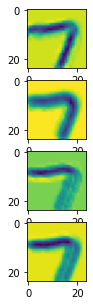

In [100]:
visualize_feature_maps(model,sample,'conv1',4)

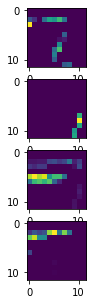

In [101]:
visualize_feature_maps(model,sample,'pool1',4)

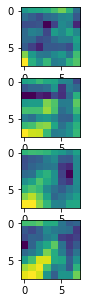

In [102]:
visualize_feature_maps(model,sample,'conv2',4)

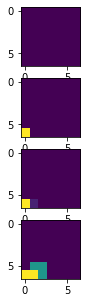

In [103]:
visualize_feature_maps(model,sample,'pool2',4)

## **visualize Kernels(Filters)**

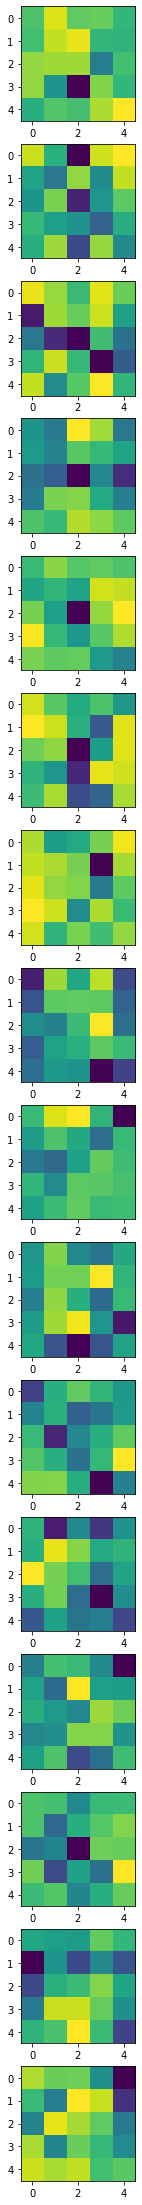

In [104]:
kernels = model.conv1.weight.detach()
fig, axarr = plt.subplots(kernels.size(0),figsize=(30, 40))
for idx in range(kernels.size(0)):
    axarr[idx].imshow(kernels[idx].squeeze())

## **Store The Model locally**

In [20]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## **Restore The Model and use it**

In [21]:
restored_model = Cnn()
restored_model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [22]:
if cuda:
  restored_model.cuda()

In [23]:
test_model(restored_model,test_dataloader)

test Accuracy: 0.972
